In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

## Start hack to get Basemap to work while Prophet is also installed
## Do not change order of imports!
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap ## this has to come after the file hack above
import fbprophet ## this and the next line have to come after importing Basemap
from fbprophet import Prophet ## in this order
## end hack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
import local
gmaps = googlemaps.Client(key=local.GOOGLE_MAP_API_KEY)
from IPython.display import display
# from jupyterthemes import jtplot
# jtplot.style()

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.
0.20.1


In [2]:
pgh_city_zip_list = ['15201', '15212', '15235', '15218', '15222', '15230', '15236', '15214', '15207', '15224', '15206', '15210', '15225', '15209', '15220', '15223', '15217', '15203', '15213', '15211', '15232', '15237', '15208', '15204', '15219', '15202', '15238', '15215', '15233', '15229', '15221', '15227']
zillow_drop_list = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
pgh_drop_list = ['PROPERTYCITY', 'PROPERTYSTATE', 'PARID', 'MUNICODE', 'DEEDBOOK', 'DEEDPAGE', 'SALEDESC', 'INSTRTYP', 'INSTRTYPDESC', 'PGH_COUNCIL_DISTRICT', 'PGH_WARD', 'PGH_PUBLIC_WORKS_DIVISION', 'PGH_POLICE_ZONE', 'PGH_FIRE_ZONE', 'TRACT', 'RECORDDATE', 'BLOCK_GROUP','SCHOOLCODE', 'SCHOOLDESC', 'MUNICODE','MUNIDESC', 'MUNICIPALITY']
arrests_drop_list = ['_id', 'PK', 'CCR', 'INCIDENTLOCATION', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION']
valid_codes = ['0', 'U', 'UR', '14', '16', '33', '34', '36', '37', 'BK']

In [3]:
zillow_medians = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')
pgh_sales = pd.read_csv('data/pgh_re_2013-2018.csv')
arrests = pd.read_csv('data/arrests_2016.csv')
zip_income = pd.read_csv('data/zip_income.csv')
pgh_hospitals = pd.read_csv('data/pgh_hospitals.csv')
demographics = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
zillow_medians.drop(zillow_drop_list, axis=1, inplace=True)
pgh_sales.drop(pgh_drop_list, axis=1, inplace=True)
arrests.drop(arrests_drop_list, axis=1, inplace=True)
pgh_hospitals.columns = ['hospital', 'address', 'lat', 'lng']
zillow_medians.rename(columns={'RegionName': 'zip_code'}, inplace=True)
pgh_time_medians = zillow_medians.loc[zillow_medians.zip_code.isin(pgh_city_zip_list)]

In [4]:
def drop_zeros(series):
    return series.astype(str).str.replace('.0', '')

In [5]:
pgh_sales.PROPERTYHOUSENUM = drop_zeros(pgh_sales.PROPERTYHOUSENUM)
pgh_sales.PROPERTYZIP = drop_zeros(pgh_sales.PROPERTYZIP)
pgh_sales = pgh_sales.loc[pgh_sales.PROPERTYZIP.isin(pgh_city_zip_list)]

In [6]:
join_list = ['PROPERTYHOUSENUM', 'PROPERTYFRACTION', 
             'PROPERTYADDRESSDIR', 'PROPERTYADDRESSSTREET', 
             'PROPERTYADDRESSSUF', 'PROPERTYADDRESSUNITDESC', 
             'PROPERTYUNITNO']
street_address = pgh_sales[join_list].apply(lambda x: ' '.join(x.astype(str)).strip().replace(' nan', ''), axis=1)
pgh_sales.drop(join_list, axis=1, inplace=True)
pgh_sales = pgh_sales.assign(street_address=street_address)
pgh_sales.rename(str.lower, axis='columns', inplace=True)
pgh_sales.rename(columns={'propertyzip': 'zip_code'}, inplace=True)
pgh_sales = pgh_sales.loc[~pgh_sales.neighborhood.isna()]
pgh_sales = pgh_sales.loc[pgh_sales.salecode.isin(valid_codes)]

In [7]:
arrests.columns = ['age', 'gender', 'race', 'arresttime', 'location', 'offenses', 'neighborhood', 'lng', 'lat']
arrests = arrests.assign(zip_code=arrests.location.map(lambda x: x[-5:]))
arrests = arrests.loc[arrests.zip_code.isin(pgh_city_zip_list)]
zip_income.columns = ['zip_code', 'median_income', 'mean_income']
zip_income.zip_code = zip_income.zip_code.astype(str)

In [8]:
demo_keep = {
    'Geography': 'zip_code', 
    'Total; Estimate; Households': 'pop',
    'Total; Estimate; Households - One race-- - White': 'white_pct',
    'Total; Estimate; Households - One race-- - Black or African American': 'black_pct'
            }
demographics = demographics[list(demo_keep.keys())]
demographics.rename(columns=demo_keep, inplace=True)
demographics.zip_code = demographics.zip_code.map(lambda x: x.replace('ZCTA5 ', '').strip())
demographics = pd.merge(demographics, zip_income, on='zip_code')
demographics = demographics.loc[demographics.zip_code.isin(pgh_city_zip_list)]

In [9]:
arrests.set_index('zip_code', inplace=True)
demographics.set_index('zip_code', inplace=True)
arrests = arrests.assign(pop=demographics['pop'])
arrests.reset_index(inplace=True)
demographics.reset_index(inplace=True)

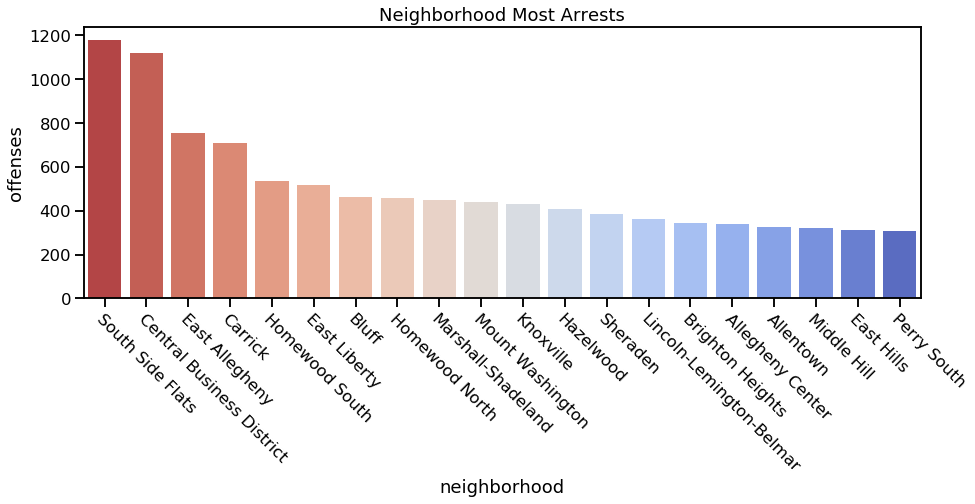

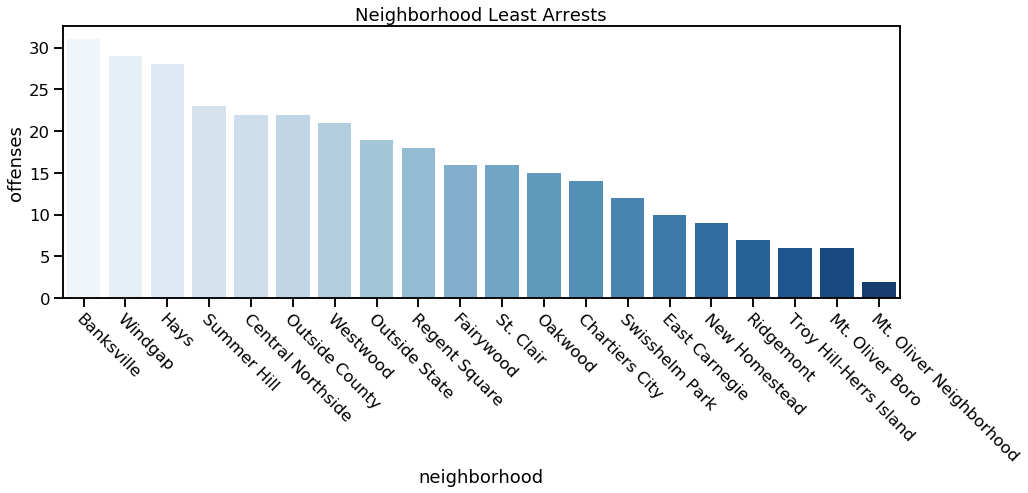

In [10]:
sns.set_context('talk')
arrests_neigh = arrests.groupby(['neighborhood'], as_index=False).agg({'offenses': 'count'})
arrests_neigh.sort_values(by='offenses', ascending=False, inplace=True)
arrests_plot = {
    'Neighborhood Most Arrests': arrests_neigh.head(20),
    'Neighborhood Least Arrests': arrests_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in arrests_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='offenses', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

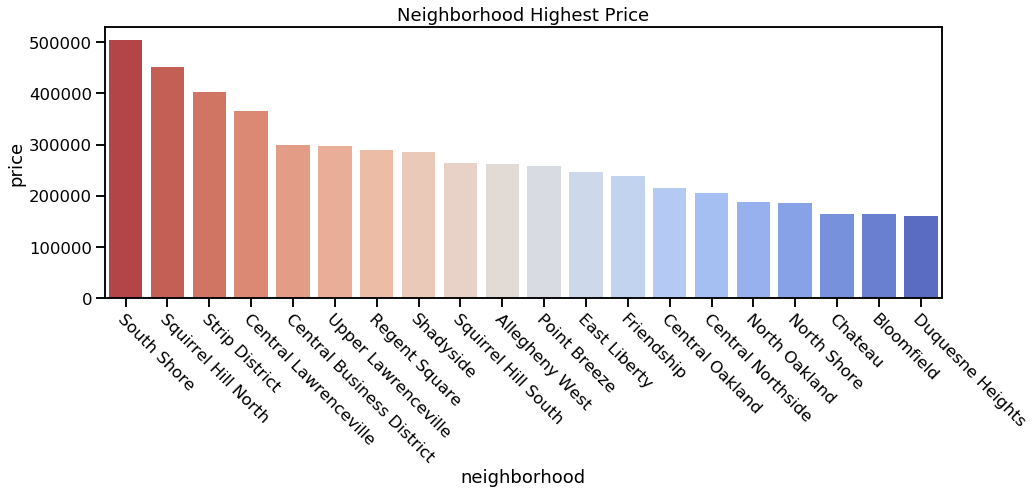

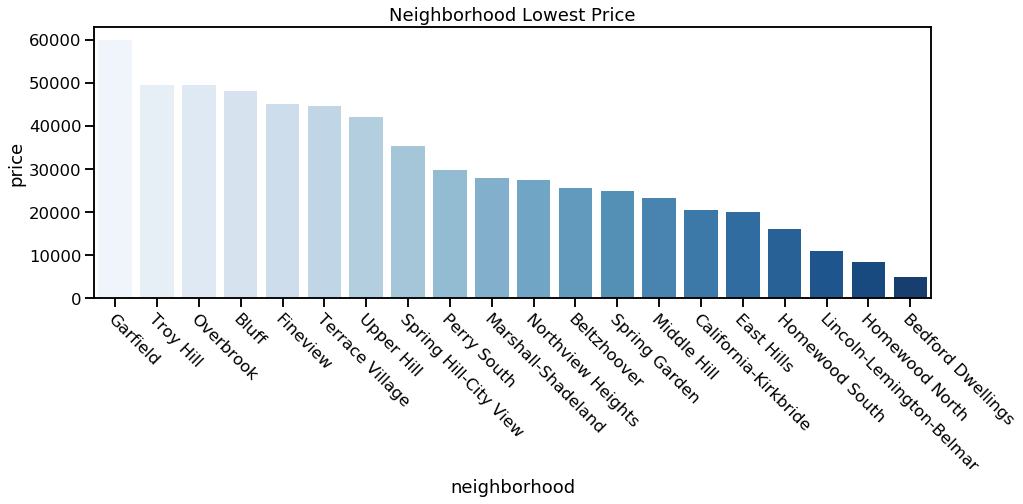

In [11]:
sales_neigh = pgh_sales.groupby(['neighborhood'], as_index=False).agg({'price': 'median'})
sales_neigh.sort_values(by='price', ascending=False, inplace=True)
sales_plot = {
    'Neighborhood Highest Price': sales_neigh.head(20),
    'Neighborhood Lowest Price': sales_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in sales_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='price', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

In [12]:
city_median = pgh_time_medians.iloc[:, 1:].median()

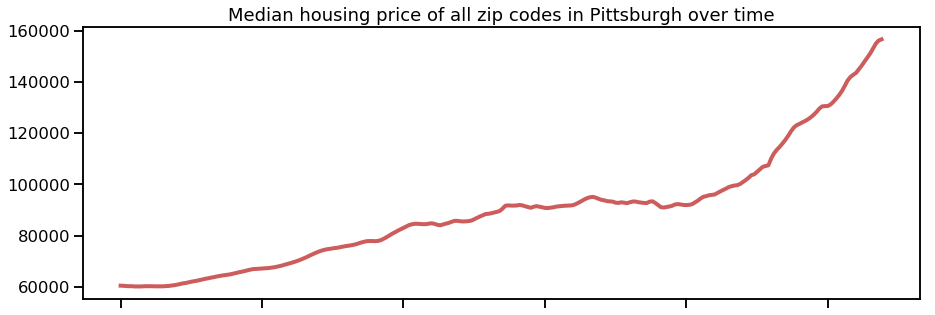

In [13]:
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all zip codes in Pittsburgh over time')
plt.show()

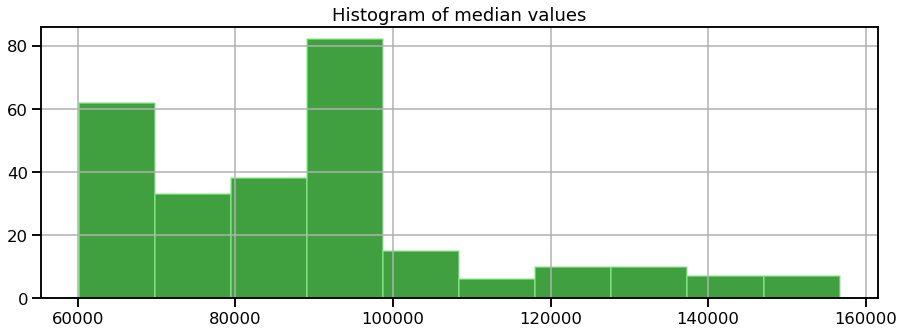

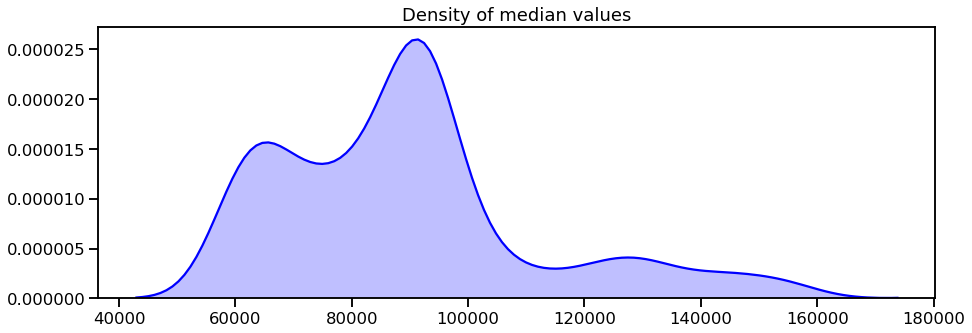

In [14]:
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

In [15]:
pgh_time_series = pgh_time_medians.copy()
pgh_time_series.rename(columns={'zip_code': 'ds'}, inplace=True)
pgh_time_series = pgh_time_series.set_index('ds').T
pgh_time_series.index = pd.to_datetime(pgh_time_series.index)

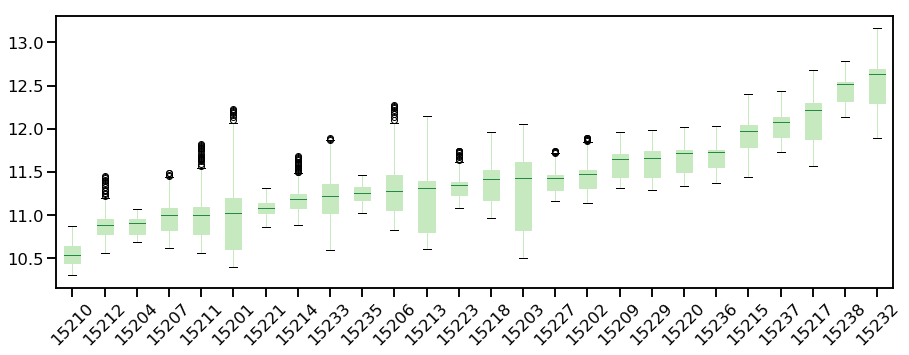

In [16]:
sns.set_palette('Greens', 3)
box_set = pgh_time_series.copy()
box_set = box_set.T.assign(median=box_set.median())
box_set.sort_values(by='median', inplace=True)
np.log(box_set.T).plot(kind='box', figsize=(15, 5), patch_artist=True)
plt.xticks(rotation=45)
plt.show()

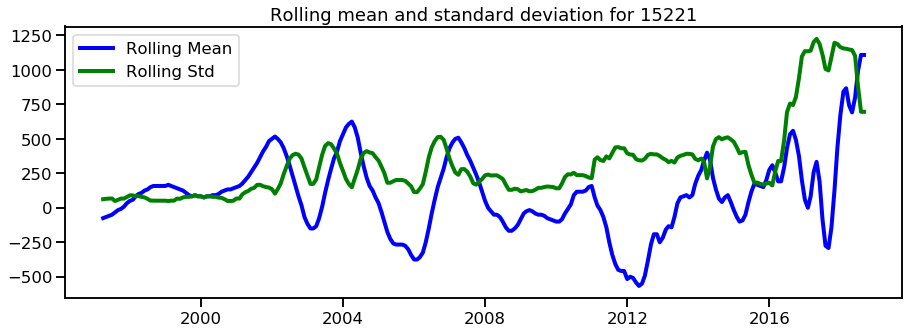

'Test results for zip 15221'

Test Statistic       -4.044854
p-value               0.001193
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

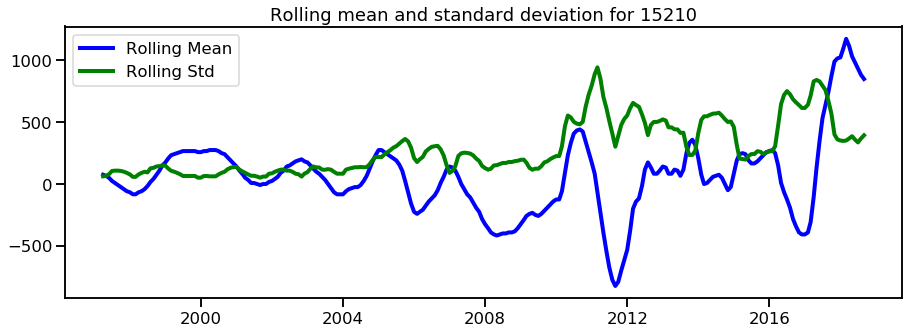

'Test results for zip 15210'

Test Statistic       -4.384561
p-value               0.000316
Critical Value 1%    -3.455461
Critical Value 5%    -2.872593
Critical Value 10%   -2.572660
dtype: float64

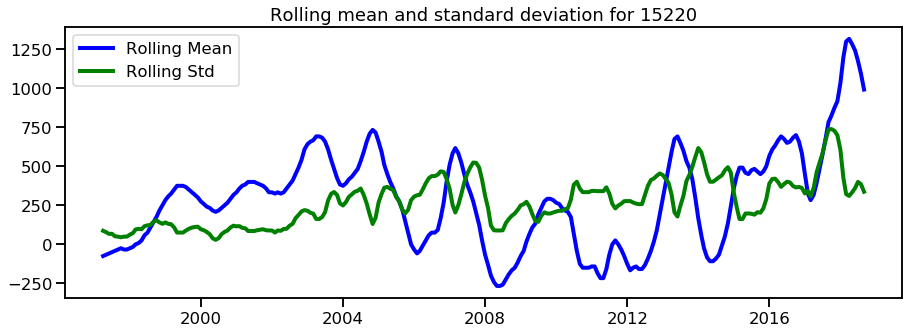

'Test results for zip 15220'

Test Statistic       -4.137556
p-value               0.000839
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

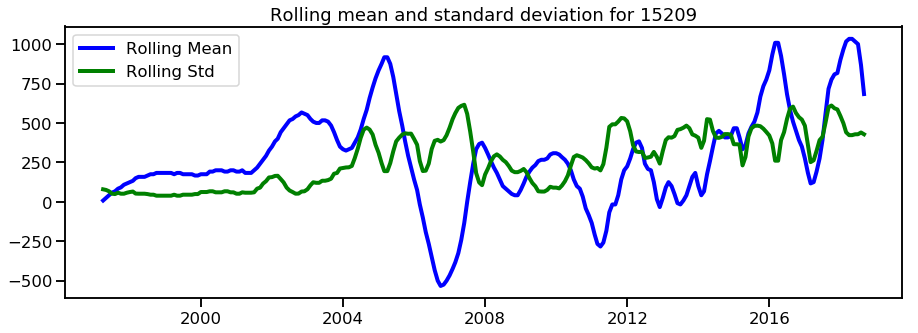

'Test results for zip 15209'

Test Statistic       -3.593597
p-value               0.005885
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

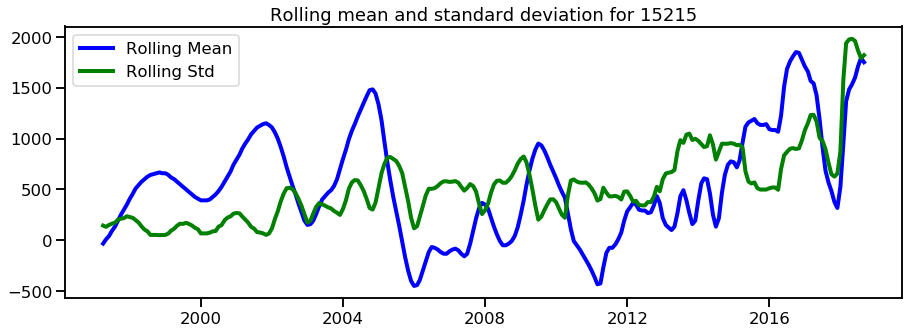

'Test results for zip 15215'

Test Statistic       -5.353022
p-value               0.000004
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

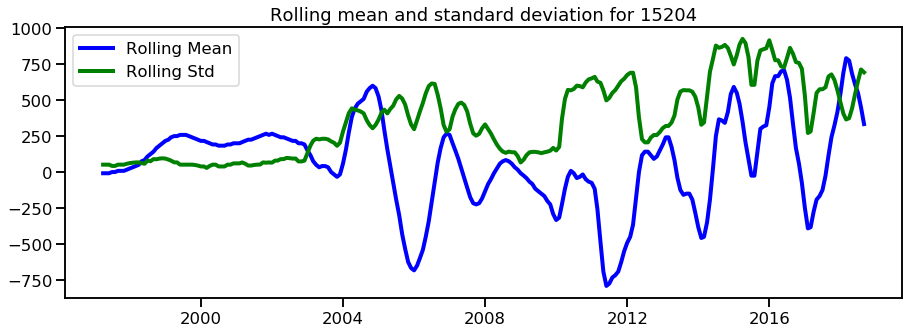

'Test results for zip 15204'

Test Statistic       -4.036288
p-value               0.001232
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

In [35]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(name: str, timeseries: pd.Series): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

def plot_time_series(name, time_series):
    plt.figure(figsize=(15, 5))
    rolmean = time_series.rolling(12).mean()
    rolstd = time_series.rolling(12).std()
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()

sta_series = {}
series_orig = {}
for series in pgh_time_series.iteritems():
    temp_series = series[1].diff()
    temp_series.dropna(inplace=True)
    name = series[0]
    results = test_stationarity(name, temp_series)
    if results[0] < results[2] and results[1] < .05:
        series_orig[name] = series[1]
        sta_series[name] = temp_series
        plot_time_series(name, temp_series)
        display(f'Test results for zip {name}', results)

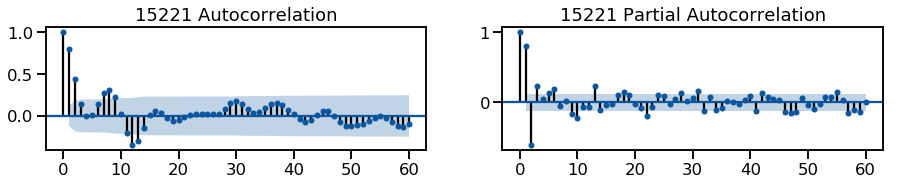

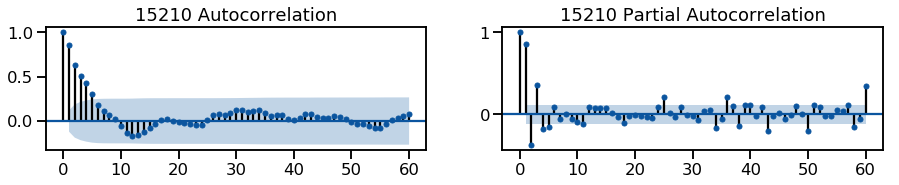

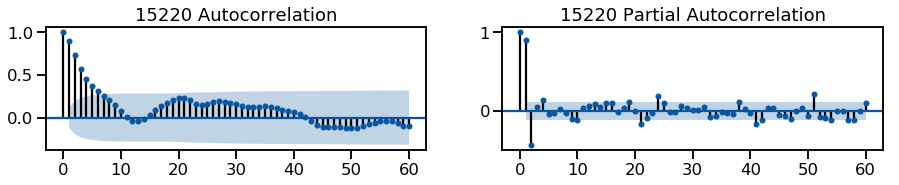

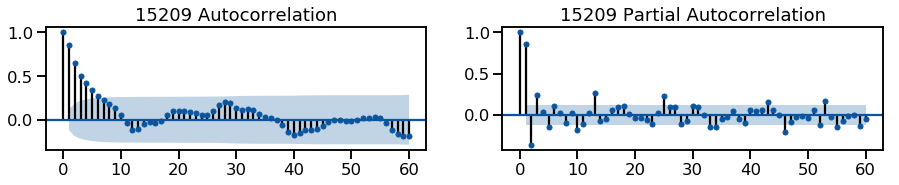

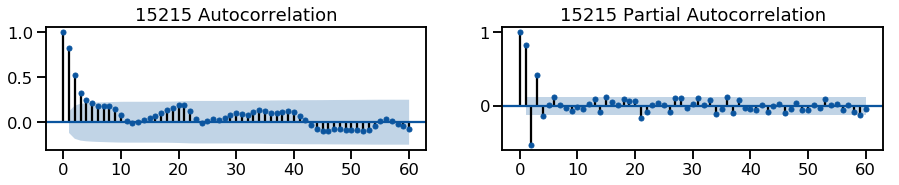

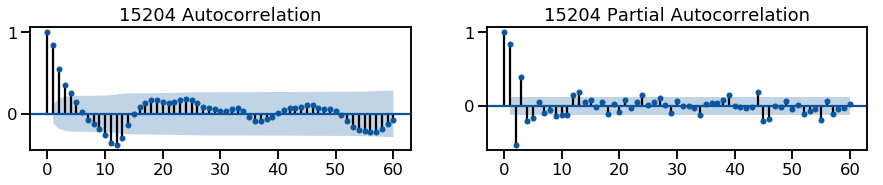

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
sns.set_palette('Blues_r')
for name, df in sta_series.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(221); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    plt.subplot(222); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')


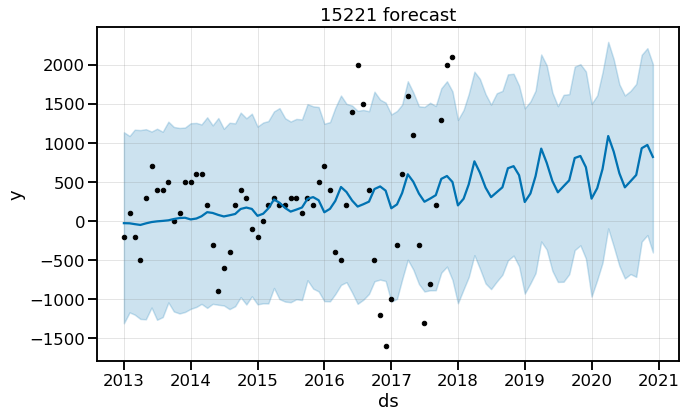

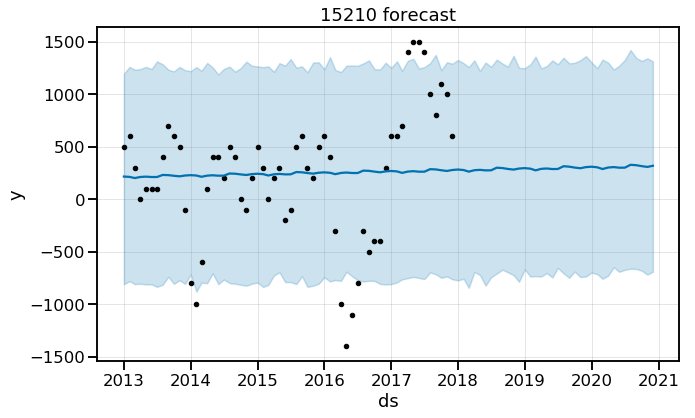

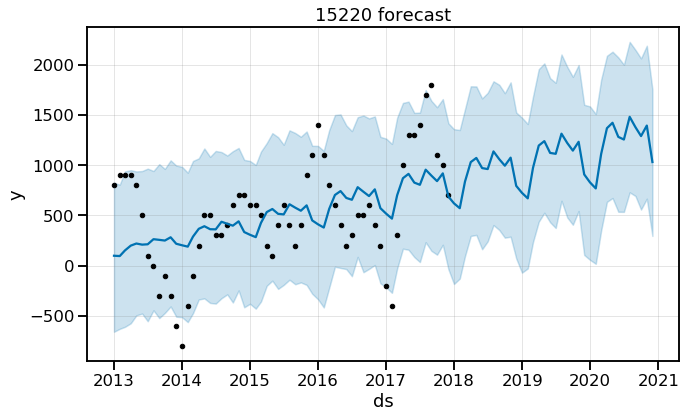

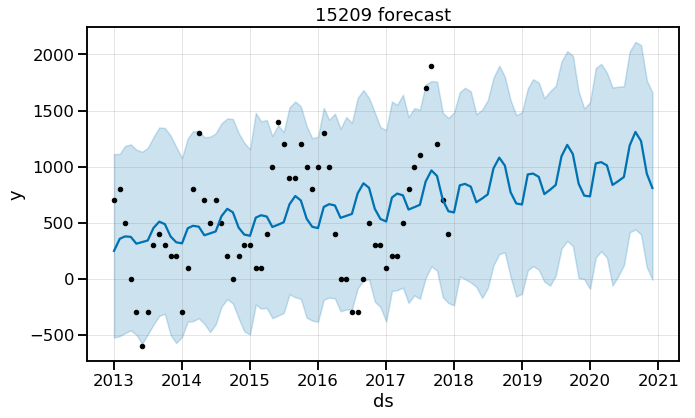

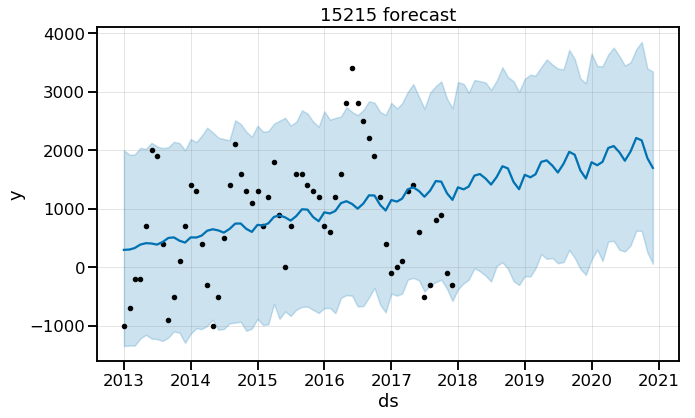

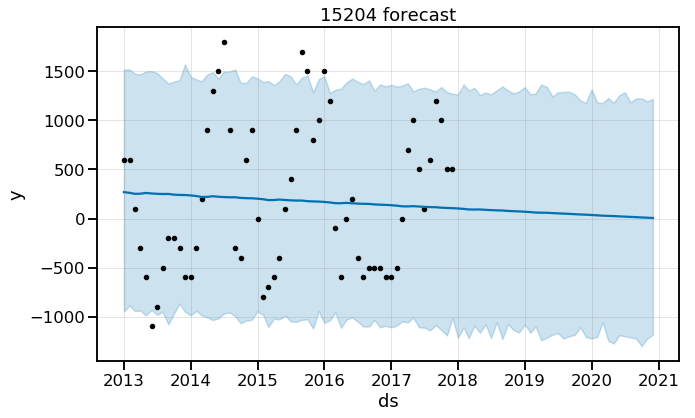

In [37]:
forecasts = {}
for name, df in sta_series.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df['2013':'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*3, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

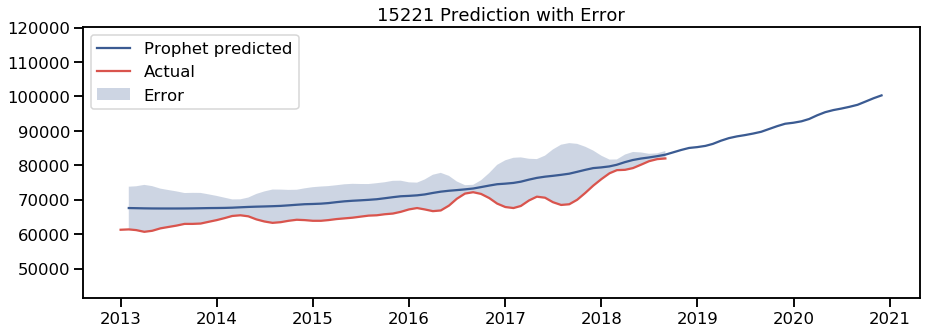

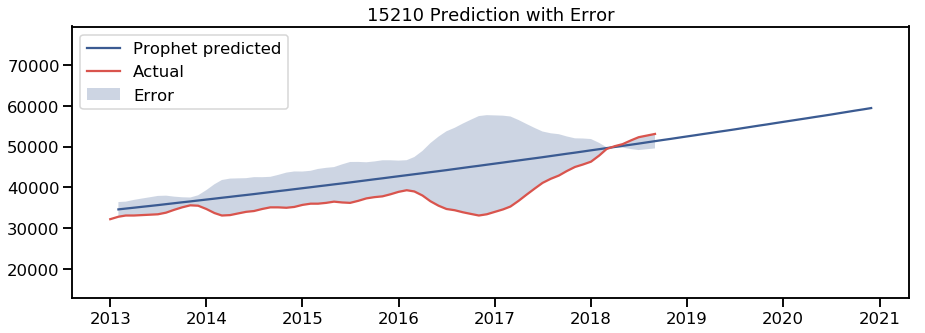

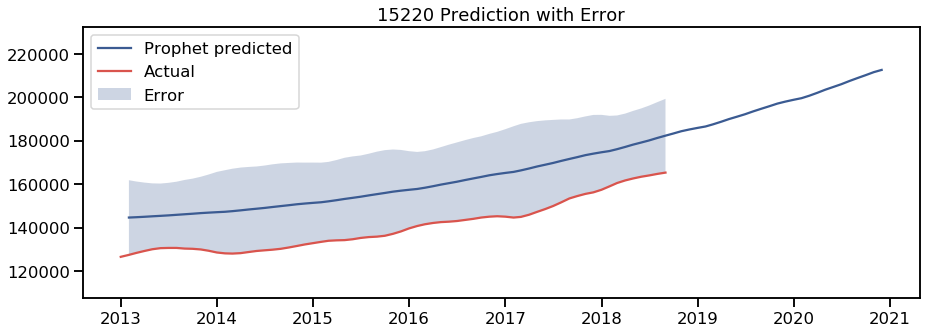

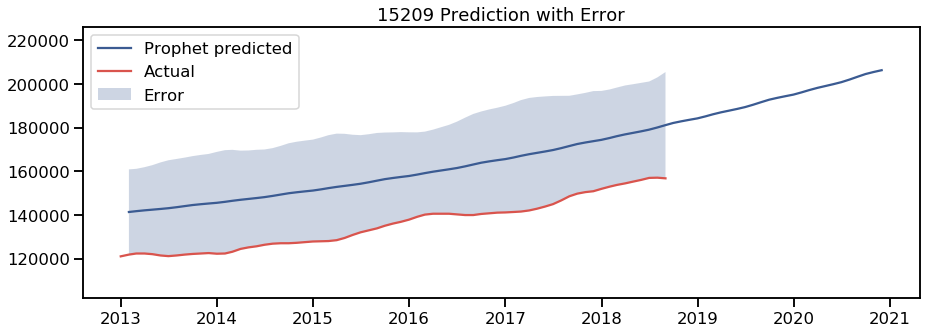

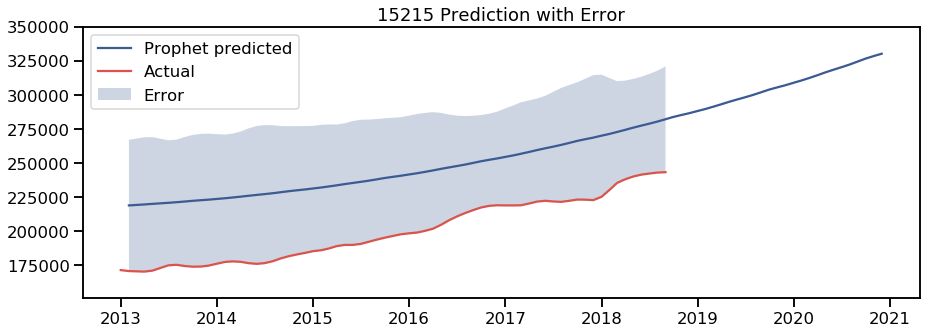

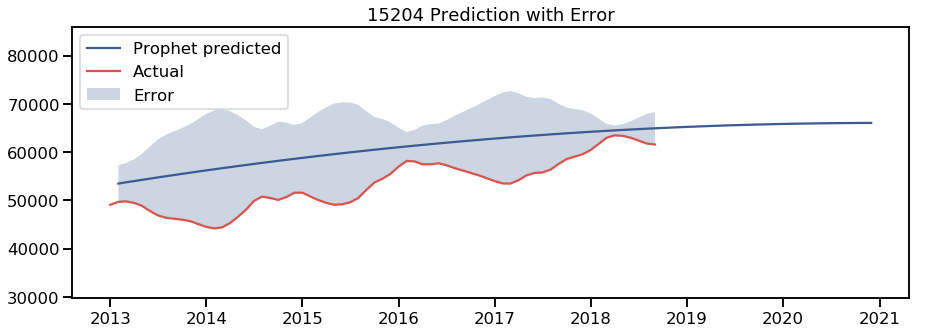

In [215]:
colors = ['denim blue', 'pale red']
sns.set_palette(sns.xkcd_palette(colors))
deltas = {}
for name, df in series_orig.items():
    temp_2018 = df.iloc[-20:]

    forecast = forecasts[f'{name} forecast']
    _pred = forecast.loc[forecast.ds > '2013']
    _pred = _pred.loc[_pred.ds < '2021']
    prophet_predict = np.r_[
        temp_2018.iloc[0],
        _pred.yhat.iloc[1:]
    ].cumsum()
    deltas[name] = {
        'delta': prophet_predict[-1] - temp_2018[-1],
        'orig': temp_2018[-1],
        'pred': prophet_predict[-1]
    }
    error = np.abs(df['2013-02-01':] - prophet_predict[:68])
    plt.figure(figsize=(15, 5))
    plt.plot(_pred.ds, prophet_predict, label='Prophet predicted')
    plt.plot(df['2013':], label='Actual')
    x = pd.to_datetime(df['2013-02-01':].index)
    y = prophet_predict[:68]
    plt.fill_between(
        x, 
        y+error,
        y-error, 
        alpha=0.25,
        label='Error'
    )
    plt.title(f'{name} Prediction with Error')
    plt.legend(loc='upper left')
    plt.ylim(bottom=(y[0]-error[0])-20000, top=np.max(prophet_predict)+20000)

In [216]:
deltas

{15221: {'delta': 18304.03838345947,
  'orig': 82000.0,
  'pred': 100304.03838345947},
 15210: {'delta': 6346.515477026347,
  'orig': 53100.0,
  'pred': 59446.51547702635},
 15220: {'delta': 47304.587518945045,
  'orig': 165300.0,
  'pred': 212604.58751894505},
 15209: {'delta': 49490.99314172298,
  'orig': 156800.0,
  'pred': 206290.99314172298},
 15215: {'delta': 86966.86141665454,
  'orig': 243200.0,
  'pred': 330166.86141665454},
 15204: {'delta': 4474.241954108977,
  'orig': 61600.0,
  'pred': 66074.24195410898}}

In [146]:
flatui = [
    sns.xkcd_rgb['windows blue'], 
    sns.xkcd_rgb['dark blue'],
]
def map_prediction_errors(data: dict):
    for name, df in data.items():
        sns.set_palette(flatui)
        df.drop('error', axis=1).plot(linewidth=4, figsize=(15, 5))
        x = df.index
        y = df.predicted
        error = df.error
        plt.fill_between(x, y-error, y+error, alpha=0.25, facecolor=flatui[1])
        plt.title(f'{name} Predicted vs. Actual: 2013 - 2018')
        plt.show()
map_prediction_errors(undiff_acc)

In [ ]:
zip_num = numerics
zip_num = zip_num.assign(date_index=zip_re.RegionName) # <-- c'mon Zillow, that's a dumb name for a zip code variable
zip_num = zip_num.set_index('date_index').T
zip_num.index = pd.to_datetime(zip_num.index)
city_num = city_num.assign(zip_code=zip_re.RegionName)

In [ ]:
"""
The offset and count here determine how many responses we get back
as a recommendation. The offset is the highest median housing value 
that we would like to focus on -- example, setting offset to 150,000
means grind() only returns zip codes with medians under that.
The count is a static value that is used below in the sort and head
functionality. A smaller count will return fewer values from grind()
"""
def grind(offset, count):
    workset = zip_num.loc['2001':]
    temp = workset['2018'].T
    workset = workset[temp.loc[
        temp.median(axis=1) < offset ## oy
    ].T.columns.values]
    five_set = workset.loc['2009': '2014']
    ten_set = workset.loc['2004': '2014']
    def find_largest_increase(dataframe):
        result = {}
        result['gross'] = dataframe.apply(lambda x: x.max() - x.min(), axis=0)
        result['percent'] = dataframe.apply(lambda x: (x.max() - x.min()) / x.min(), axis=0)
        result = pd.DataFrame.from_dict(result).reset_index()
        result.columns = ['zip', 'gross', 'percent']
        return result
    five_raise = find_largest_increase(five_set)
    ten_raise = find_largest_increase(ten_set)
    top_percent = list(
        set(five_raise.sort_values(by='percent', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='percent', ascending=False).head(count).zip.values)
    )
    top_gross = list(
        set(five_raise.sort_values(by='gross', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='gross', ascending=False).head(count).zip.values)
    )
    return [zip_code for zip_code in top_percent if zip_code in top_gross]

In [ ]:
full = grind(150e3, round(zip_num.shape[1] * .005)) ## this returns 10 values at time of publishing
full_monty = zip_re.loc[zip_re.RegionName.isin(full)]
drop = ['SizeRank', 'RegionID', 'CountyName']
full_monty.drop(drop, axis=1, inplace=True)
full_monty = full_monty.assign(
    zip_code=full_monty.RegionName, 
    city=full_monty.City, 
    state=full_monty.State,
    metro=full_monty.Metro
)
full_monty.drop(['RegionName', 'City', 'State', 'Metro'], axis=1, inplace=True)
high_zip = zip_num[full]
high_zip.shape

In [ ]:
"""
This takes a second and makes about 10 calls to the Google Maps API.
"""
geocode_results = {}
for zip_code in list(high_zip):
    temp = full_monty.loc[full_monty.zip_code == zip_code]
    temp = temp.drop(full_monty.columns[range(0, 249)], axis=1)
    temp = temp.drop(['zip_code', 'city', 'state', 'metro'], axis=1)
    name = full_monty.loc[full_monty.zip_code == zip_code, 'city'].values[0]
    increase = (temp.T.iloc[-1] - temp.T.iloc[0]).values[0]
    zip_code = str(zip_code)
    
    if len(zip_code) < 5:
        zip_code = f'0{zip_code}'
        
    geocode = gmaps.geocode(zip_code)[0]
    geocode_results[name] = {
        'increase' : increase,
        'zip': zip_code,
        'lng': geocode['geometry']['location']['lng'],
        'lat': geocode['geometry']['location']['lat'],
    }

In [ ]:
## this takes 20 - 30 seconds. to speed it up 
## change the 'resolution' value in the Basemap constructor to 'c' (for crude)
plt.figure(figsize=(20, 10))
m = Basemap(
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    projection='lcc', 
    lat_1=33,
    lat_2=45,
    lon_0=-95,
    resolution='i' ## oy!
)
gray = 'b'
m.drawcoastlines(color=gray, linewidth=1)
m.drawstates(color=gray, linewidth=1)
m.drawcountries(color=gray, linewidth=1)
for city in geocode_results.items():
    x, y = m(city[1]['lng'], city[1]['lat'])
    m.scatter(
        x, y, 
        color='g', 
        s=city[1]['increase'] * .01, 
        alpha=.75,
        edgecolor='white',
        linewidth=1
    )
plt.show()

In [ ]:
print('Increased value in the "simple algorithmic" recommended areas from January 2017 to September 2018')
display(pd.DataFrame.from_dict(geocode_results).loc[['zip', 'increase']].T.sort_values(by='increase', ascending=False))
print(u'\u2B06', 'Fresno: The Armpit of California')

In [ ]:
test_show_ad(high_zip)

In [ ]:
metro_diffed = {}
for name, timeseries in high_zip.iteritems():
    diff = np.log(timeseries)
    name = f'{name} log'
    diff.dropna(inplace=True)
    metro_diffed[name] = diff
test_show_ad(metro_diffed)

In [ ]:
forecasts = {}
for name, df in metro_diffed.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df[:'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*5, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

In [ ]:
jtplot.style()
sns.set_context('talk')
for name, df in high_zip.iteritems():
    sns.set_palette('Set3')
    temp_2018 = df.iloc[-20:]
    _pred = forecasts[f'{name} log forecast'].loc[
        pd.to_datetime(forecasts[f'{name} log forecast'].ds) > '2017'
    ]
    _pred = _pred.loc[_pred.ds < '2020']
    ds = _pred.ds
    _pred = _pred.drop('ds', axis=1).apply(np.exp)
    _pred.columns = ['predicted', 'yhat_lower', 'yhat_upper']
    _pred = _pred.assign(ds=ds)
    _pred.set_index('ds').drop(['yhat_lower', 'yhat_upper'], axis=1).plot(
        linewidth=4,
        figsize=(15, 5)
    )
    plt.plot(temp_2018, label='actual')
    x = pd.to_datetime(ds.values)
    y = _pred.yhat_lower
    error = _pred.yhat_upper
    plt.fill_between(
        x, 
        _pred.yhat_lower,
        _pred.yhat_upper, 
        alpha=0.25,
        label='Prophet confidence interval'
    )
    plt.title(f'{name}')
    plt.legend(loc='upper left')
    plt.ylim(bottom=50000)

In [ ]:
##################################################
### don't do this. it takes about an hour. #######
### not worth it. i made a csv. read from that.###
##################################################

# lat_lngs = {}
# missing = []
# counter = 0
# for zip_code in whole_enchilada.zip_code:
#     if counter %  1000 == 0:
#         print('.')
#     counter += 1
#     geocode = gmaps.geocode(zip_code)
#     if not len(geocode):
#         missing.append(zip_code)
#         continue
#     geocode = geocode[0]
#     lat_lngs[zip_code] = {
#         'lng': geocode['geometry']['location']['lng'],
#         'lat': geocode['geometry']['location']['lat']
#     }
# def fix_missing(missing):
#     counter = 0
#     for zip_code in missing:
#         if counter %  100 == 0:
#             print('.')
#         counter += 1
#         geocode = gmaps.geocode(zip_code)
#         if not len(geocode):
#             continue
#         geocode = geocode[0]
#         lat_lngs[zip_code] = {
#             'lng': geocode['geometry']['location']['lng'],
#             'lat': geocode['geometry']['location']['lat']
#         }
#         if lat_lngs[zip_code]['lng'] and lat_lngs[zip_code]['lat']:
#             print('got one')
#             missing.remove(zip_code)
# fix_missing(missing)
# print('ding, fries are done.')
# pd.DataFrame.from_dict(lat_lngs).to_csv('data/lat_lngs.csv')

#######################
### do this instead ###
#######################
lat_lngs = pd.read_csv(
    'data/lat_lngs.csv',
    usecols=['zip_code', 'lat', 'lng'],
    dtype={
        'zip_code': str
    }
)
pop_income = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
pop_income = pop_income.assign(zip_code=lambda x: x['Geography'].str.replace('ZCTA5', '').str.strip())
temp = pop_income.iloc[:, 1:3]
temp.columns = ['pop', 'income']
temp = temp.assign(zip_code=pop_income.zip_code)
whole_new = temp.copy()
temp = pd.DataFrame({'zip_code': zip_num.median().index.astype(str), 'label': zip_num.median().values})
whole_new = pd.merge(whole_new, temp)
whole_new = pd.merge(whole_new, lat_lngs)

In [ ]:
sns.set_style(
    'ticks',
    {
        'figure.facecolor': jtplot.base_style['figure.facecolor'],
        'axes.facecolor': jtplot.base_style['figure.facecolor']
    }
)
ll_map = whole_new.drop(whole_new.loc[whole_new.lng < -130].index)
ll_map.drop(ll_map.loc[ll_map.label < 1000].index, inplace=True)
ll_map.loc[ll_map.label >= 750000, 'label'] = 750000
ll_map.dropna(inplace=True)
ll_map['median price category'] = pd.cut(ll_map['label'], 3, labels=['low', 'mid', 'high'])
plt.figure(figsize=(16, 9))
sns.scatterplot(
    x=ll_map['lng'], y=ll_map['lat'], alpha=0.55,
    s=ll_map['pop'] / 200,
    hue=ll_map['median price category'],
    palette=('coolwarm'),
    legend=False
)
recs = pd.DataFrame.from_dict(geocode_results).T
recs = recs.assign(recommended='yep')
sns.scatterplot(
    x=recs['lng'],
    y=recs['lat'],
    s=200, alpha=.75,
    hue=recs['recommended'],
    palette='Greens',
    legend='brief'
)
plt.title('Median Price Category and Early Recommendations')
plt.legend(loc='lower left')
plt.show()